### 1. Read data from csv files

In [9]:
import csv

csvFile = open("BCHAIN-MKPRU.csv", "r")
reader = csv.reader(csvFile)
date={}
bitcoin = {} # map from day t (0~N) to price of bitcoin
i=0
for item in reader:
    if reader.line_num == 1:
        continue
    bitcoin[i] = float(item[1])
    date[i]=item[0]
    i=i+1

csvFile.close()

csvFile = open("LBMA-GOLD.csv", "r")
reader = csv.reader(csvFile)
j=0
gold = {} # map from day t (0~N) to price of gold
for item in reader:
    if reader.line_num == 1:
        continue
    while(item[0]!=date[j]):
        gold[j] = 0
        j=j+1
    if(item[1]==''): gold[j]=0
    else: gold[j]=float(item[1])
    j=j+1

csvFile.close()

In [10]:
# Buy kind with cash C
def buy(C, G, B, date, kind, amount, allin=False):
    trade=0
    price=0
    a=0
    if(kind=='gold'):
        if(gold[date]==0): return 0
        a=ag
        price=gold[date]
        trade=amount*gold[date]*(1+a)
    if(kind=='bitcoin'):
        a=ab
        price=bitcoin[date]
        trade=amount*bitcoin[date]*(1+a)
    if(C<trade or allin==True):
        amount=C/(price*(1+a))
        C=0
        if(kind=='gold'): G=G+amount
        if(kind=='bitcoin'): B=B+amount
    else:
        C=C-trade
        if(kind=='gold'): G=G+amount
        if(kind=='bitcoin'): B=B+amount
    return C, G, B, amount

# Sell kind
def sell(C, G, B, date, kind, amount, allin=False):
    price=0
    a=0
    if(kind=='gold'):
        if(gold[date]==0): return C, G, B, 0
        a=ag
        if(amount>G or allin==True): amount=G
        G=G-amount
        price=amount*gold[date]
    if(kind=='bitcoin'):
        a=ab
        if(amount>B or allin==True): amount=B
        B=B-amount
        price=amount*bitcoin[date]
    trade=price-price*a
    C=C+trade
    return C, G, B, amount

# Weighted average of price over a period of time
def average(start, kind, days, decay_rate=0.95):
    if(kind=='gold'):
        price=0
        count=0
        weight_sum=0
        now=start
        while(days>0):
            if(now<0):
                break
            if(gold[now]==0):
                days=days-1
                now=now-1
            else:
                factor=decay_rate**count
                price=price+gold[now]*factor
                weight_sum+=factor
                count=count+1
                now=now-1
                days=days-1
        if(count==0): return 0
        # return (price/count)
        return (price/weight_sum)
    if(kind=='bitcoin'):
        price=0
        count=0
        weight_sum=0
        now=start
        while(days>0):
            if(now<0):
                break
            factor=decay_rate**count
            price=price+bitcoin[now]*factor
            weight_sum+=factor
            count=count+1
            now=now-1
            days=days-1
        if(count==0): return 0
        return (price/weight_sum)
    
# The rate of increase over a period of time
def rate(start, kind, P, L, decay_rate=0.95):
    priceP=average(start, kind, P, decay_rate)
    priceL=average(start, kind, L, decay_rate)
    if(priceL==0): return 0
    return (priceL-priceP)/priceP

In [11]:
# Get the latest price of a type
def get_latest_price(type,day):
        dic=None
        if type=='gold': dic=gold
        elif type=='bitcoin': dic=bitcoin
        while(dic[day]==0): day-=1
        return dic[day]

# Find the best time lags up to i-th day
def find_LP(C,B,G,i_th_day,old_L,old_P,mode,Lrange=(10,30),Prange=(10,90)):
    ag=0.01
    ab=0.02
    Lnum=range(*Lrange)
    Pnum=range(*Prange)
    cf,lf,pf=0,0,0
    for l in Lnum:
        for p in Pnum:
            if(l>=p): continue
            C_t,G_t,B_t=result(C=C, B=B, G=G, Days=i_th_day-1, ag=ag, ab=ab, L=l, P=p,
                        sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0, decay_rate=0.95)
            c1=C_t + G_t*get_latest_price('gold',i_th_day-1) + B_t*get_latest_price('bitcoin',i_th_day-1)
            if(c1>cf):
                cf=c1
                pf=p
                lf=l
    # new L, P will average with old L,P
    if mode == 1:
        pf = round((pf+old_P)/2)
        lf = round((lf+old_L)/2)
    # print(pf,lf)
    return lf, pf

In [12]:
# The investment result with fixed time lags L, P
def result(C, B, G, Days, ag, ab, L, P, sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0, decay_rate=0.95):
    for i in range(Days):
        if(i<P): continue
        rateGold=rate(i, 'gold', P, L,decay_rate)
        rateBitcoin=rate(i, 'bitcoin', P, L,decay_rate)
        if(gold[i]!=0):
            if(rateGold>0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'gold', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin>0):
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold>0 and rateBitcoin>0):
                total=rateGold+rateBitcoin
                aGold=rateGold/total
                aBitcoin=rateBitcoin/total
                Cgold=aGold*C
                Cbitcoin=aBitcoin*C
                C, G, B, amount=buy(Cgold, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(Cbitcoin, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
        else:
            if(rateBitcoin>0):
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
    C, G, B, amount=sell(C, G, B, Days-1, 'gold', amount=0, allin=True)
    C, G, B, amount=sell(C, G, B, Days-1, 'bitcoin', amount=0, allin=True)
    return C,G,B

In [13]:
from tqdm import tqdm

# The investment result with dynamic time lags L, P
def final_result(C, B, G, Days, ag, ab, sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0, decay_rate=0.95):
    L,P = 50,100
    P0=P
    Cs,Bs,Gs,totals=[],[],[],[]
    for i in tqdm(range(Days)):
        if(i<P0): continue
        if(i%150==0):
            dL=int(5+25**(1-i/Days))
            dP=int(5+50**(1-i/Days))
            # print('dL',dL,'dP',dP)
            L,P = find_LP(C,B,G,i,L,P,2,(L-dL,L+dL),(P-dP,P+dP))
        rateGold=rate(i, 'gold', P, L,decay_rate)
        rateBitcoin=rate(i, 'bitcoin', P, L,decay_rate)
        if(gold[i]!=0):
            if(rateGold>0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'gold', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin>0):
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold>0 and rateBitcoin>0):
                total=rateGold+rateBitcoin
                aGold=rateGold/total
                aBitcoin=rateBitcoin/total
                Cgold=aGold*C
                Cbitcoin=aBitcoin*C
                C, G, B, amount=buy(Cgold, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(Cbitcoin, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
        else:
            if(rateBitcoin>0):
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
        Cs.append(C)
        Gs.append(G)
        Bs.append(B)
        totals.append(C+G*get_latest_price('gold',i)+B*get_latest_price('bitcoin',i))
    C, G, B, amount=sell(C, G, B, Days-1, 'gold', amount=0, allin=True)
    C, G, B, amount=sell(C, G, B, Days-1, 'bitcoin', amount=0, allin=True)
    return C,G,B,Cs,Gs,Bs,totals

In [14]:
# Run the algorithm
ag=0.01
ab=0.02
c1,c2,c3,Cs,Gs,Bs,totals=final_result(C=1000, B=0, G=0, Days=len(bitcoin), ag=ag, ab=ab, sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0)
print("The total asset in the end: %.2f"%(c1))

100%|██████████| 1826/1826 [07:59<00:00,  3.80it/s]

The total asset in the end: 49902.04


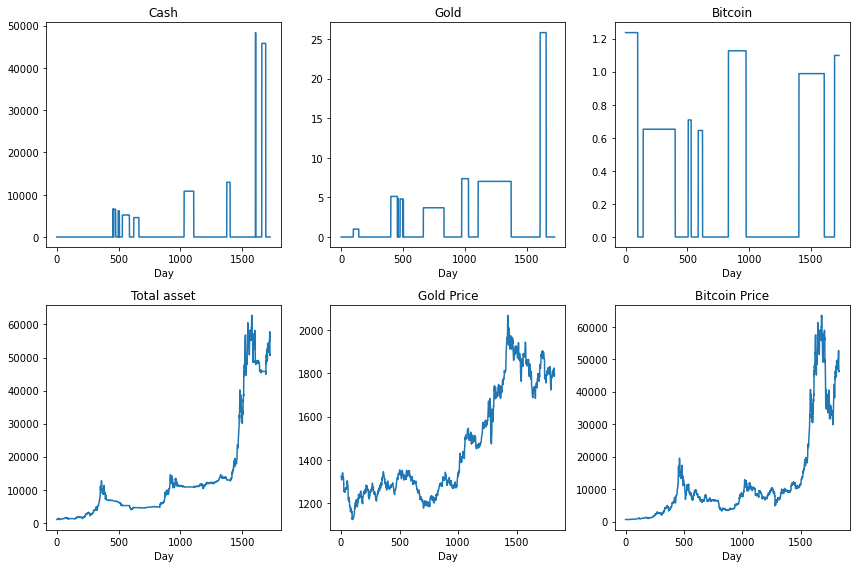

In [15]:
import matplotlib.pyplot as plt

# Visualization of results
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(Cs)
plt.xlabel('Day')
plt.title('Cash')
plt.subplot(2,3,2)
plt.plot(Gs)
plt.xlabel('Day')
plt.title('Gold')
plt.subplot(2,3,3)
plt.plot(Bs)
plt.xlabel('Day')
plt.title('Bitcoin')
plt.subplot(2,3,4)
plt.plot(totals)
plt.xlabel('Day')
plt.title('Total asset')
plt.subplot(2,3,5)
plt.plot([t for t in gold.keys() if gold[t]!=0],[gold[t] for t in gold.keys() if gold[t]!=0])
plt.xlabel('Day')
plt.title('Gold Price')
plt.subplot(2,3,6)
plt.plot(bitcoin.keys(),bitcoin.values())
plt.xlabel('Day')
plt.title('Bitcoin Price')
plt.tight_layout()
